In [1]:
import torch
import monai
from glob import glob
from monai.transforms import Compose
from pathlib import Path
import torchio as tio
import os
from tqdm import tqdm
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import monai.networks
import monai.networks.nets
from dataset import DeepLesionDataset
from model import get_model
from sklearn.decomposition import PCA

/home/moonsurfer/miniconda3/envs/medicaldino/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_2359603/3765682276.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(checkpoint_path)["state_dict"]
100%|██████████| 1221/1221 [05:47<0

Running t-SNE...


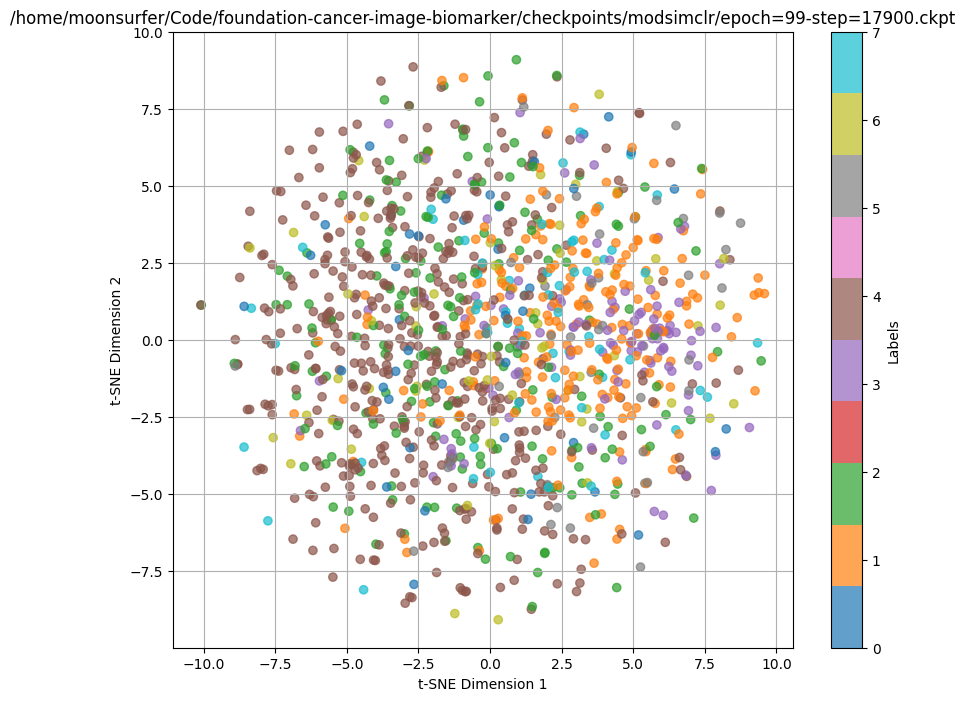

In [2]:
data_path = "/home/moonsurfer/Code/foundation-cancer-image-biomarker/data/preprocessing/deeplesion/annotations/task1_test.csv"
dataset = DeepLesionDataset(args=None, path=data_path, transform="inference", radius=25)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1) 

model = monai.networks.nets.resnet.resnet50(pretrained=False, n_input_channels=1, widen_factor=2, conv1_t_stride=2, feed_forward=False)
checkpoint_path = "/home/moonsurfer/Code/foundation-cancer-image-biomarker/checkpoints/modsimclr/epoch=99-step=17900.ckpt"
weights = torch.load(checkpoint_path)["state_dict"]
model.load_state_dict(weights, strict=False)
model.cuda()

features = []
labels = []
dims = []
df = pd.read_csv(data_path)

for volume, filepath in tqdm(dataloader):                

    file_id = filepath[0].split("/")[-1]
    label = df[df["Volume_fn"] == file_id]["Coarse_lesion_type"].iloc[0].item()
    volume = volume.to(torch.float32).cuda()
    out = model(volume) 
    labels.append(label)
    features.append(out.detach().cpu())                

features = torch.concatenate(features)        
labels = torch.from_numpy(np.array(labels))            

data_np = features.cpu().numpy()
labels_np = labels.cpu().numpy()

# Perform t-SNE to reduce dimensionality to 2D
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_2d = tsne.fit_transform(data_np)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels_np, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, ticks=range(8), label="Labels")
plt.title(f"{checkpoint_path}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

    